In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from datasets import load_dataset

/home/yosh/gradio-demo/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("ylecun/mnist")

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))  
])

def preprocess_ops(examples):
    examples['image'] = [preprocess(image) for image in examples['image']]
    return examples

dataset.set_transform(preprocess_ops)
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


In [3]:
train_dataset, test_dataset = dataset['train'], dataset['test']

In [4]:
batch_size = 128
trainLoader = DataLoader(train_dataset, batch_size=batch_size)
testLoader = DataLoader(test_dataset, batch_size)

In [6]:
class CNN(nn.Module):
    def __init__(self, n_filters, hidden_dim, n_layers):
        super().__init__()
        self.conv1 = nn.Conv2d(1, n_filters, 5)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(n_filters, 2*n_filters, 5)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2)
        self.input_dim = 960
        self.flatten = nn.Flatten()
        self.inp_layer = nn.Linear(self.input_dim, hidden_dim)
        self.classifier = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(p=0.3)
            ) for i in range(n_layers)
        ])
        self.out_layer = nn.Linear(hidden_dim, 10)

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = self.inp_layer(torch.flatten(x, start_dim=1))
        for layer in self.classifier:
            x = layer(x)
        x = self.out_layer(x)
        return x


    
params = {
    'n_filters': 30,
    'hidden_dim': 100,
    'n_layers': 2
}
model = CNN(**params)
n_params = sum([p.numel() for p in model.parameters()])
print(f'Number of params {n_params}')

Number of params 163550


In [ ]:
batch_size = 128
lr = 0.001
n_epochs = 5

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train(model, trainLoader, testLoader, criterion, optimizer, n_epochs):
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    for epoch in range(1, n_epochs+1):
        model.train()
        train_loss = 0
        train_acc = 0
        for batch in tqdm(trainLoader):
            data, labels = batch['image'], batch['label']
            out = model(data)
            preds = out.argmax(dim=1)
            loss = criterion(out, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (preds == labels).sum().item()

        train_loss /= len(trainLoader)
        train_acc /= len(trainLoader.dataset)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0
        test_acc = 0
        with torch.no_grad():
            for batch in tqdm(testLoader, disable=True):
                data, labels = batch['image'], batch['label']
                out = model(data)
                loss = criterion(out, labels)
                preds = out.argmax(dim=1)
                test_loss += loss.item()
                test_acc += (preds == labels).sum().item()

        test_loss /= len(testLoader)
        test_acc /= len(testLoader.dataset)
        test_accs.append(test_acc)
        test_losses.append(test_loss)

        print(f'epoch {epoch} | train loss {train_loss:.3f} train acc {train_acc:.2f} | test loss {test_loss:.3f} test acc {test_acc:.2f}')
    return train_losses, train_accs, test_losses, test_accs


In [45]:
train_losses, train_accs, test_losses, test_accs = train(model, trainLoader, testLoader, criterion, optimizer, n_epochs)

100%|██████████| 469/469 [00:29<00:00, 15.79it/s]


epoch 1 | train loss 0.224 train acc 0.95 | test loss 0.046 test acc 0.99


100%|██████████| 469/469 [00:27<00:00, 17.23it/s]


epoch 2 | train loss 0.057 train acc 0.98 | test loss 0.032 test acc 0.99


100%|██████████| 469/469 [00:29<00:00, 15.81it/s]


epoch 3 | train loss 0.041 train acc 0.99 | test loss 0.027 test acc 0.99


100%|██████████| 469/469 [00:35<00:00, 13.40it/s]


epoch 4 | train loss 0.030 train acc 0.99 | test loss 0.033 test acc 0.99


100%|██████████| 469/469 [00:26<00:00, 17.39it/s]


epoch 5 | train loss 0.025 train acc 0.99 | test loss 0.030 test acc 0.99


100%|██████████| 469/469 [00:31<00:00, 14.79it/s]


epoch 6 | train loss 0.022 train acc 0.99 | test loss 0.032 test acc 0.99


100%|██████████| 469/469 [00:30<00:00, 15.28it/s]


epoch 7 | train loss 0.018 train acc 0.99 | test loss 0.031 test acc 0.99


100%|██████████| 469/469 [00:27<00:00, 16.83it/s]


epoch 8 | train loss 0.016 train acc 0.99 | test loss 0.030 test acc 0.99


100%|██████████| 469/469 [00:28<00:00, 16.74it/s]


epoch 9 | train loss 0.014 train acc 1.00 | test loss 0.032 test acc 0.99


100%|██████████| 469/469 [00:28<00:00, 16.67it/s]


epoch 10 | train loss 0.013 train acc 1.00 | test loss 0.026 test acc 0.99


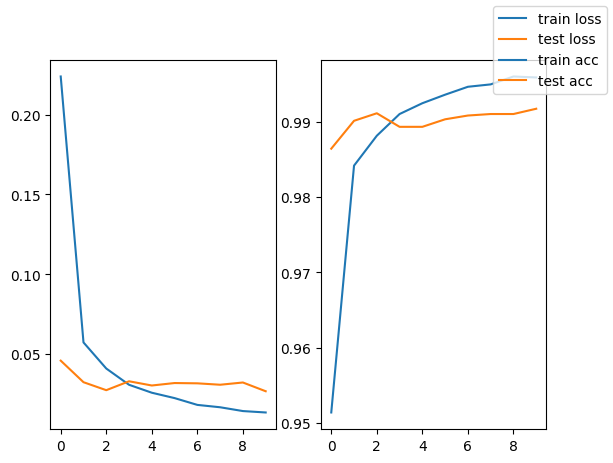

In [50]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(train_losses, label='train loss')
ax[0].plot(test_losses, label='test loss')
ax[1].plot(train_accs, label='train acc')
ax[1].plot(test_accs, label='test acc')
fig.legend()

In [51]:
# save model
torch.save(model.state_dict(), 'mnist_model.pth')

In [ ]:
# test
idx = torch.randint(0, 100)
img, label = test_dataset['image'][idx], test_dataset['image'][idx]
plt.imshow(img)

In [ ]:
img.shape

In [ ]:
with torch.no_grad():
    